<a href="https://colab.research.google.com/github/dinbav/Hogwarts-School-of-RAG/blob/main/RAG_Workshop_4sharing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Building a Retrieval-Augmented Generation (RAG) System with LangChain and Hugging Face Transformers
Let's walk through the process of building a Retrieval-Augmented Generation (RAG) system using LangChain, FAISS, and Hugging Face transformers. Our goal is to create a powerful question-answering system that retrieves relevant documents from a knowledge base and generates answers using a large language model. Let's dive into the details, step-by-step.
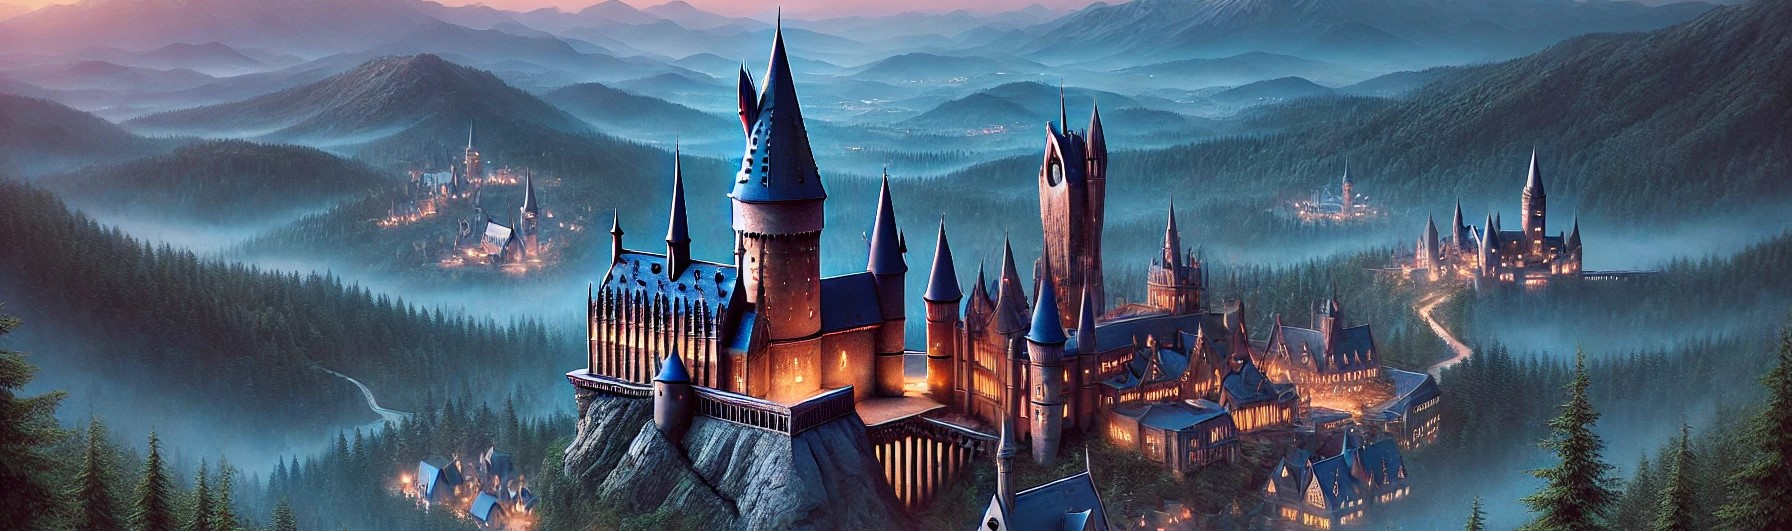

## Installing Dependencies

**This section installs the required libraries:**
* **LangChain:** A framework for building applications with language models.
* **Accelerate:** A library to accelerate PyTorch models.
* **Bits and Bytes (bnb):** A library for model quantization.
* **Transformers:** A library by Hugging Face that provides various pretrained models.
* **Sentence-Transformers:** A library for sentence embeddings.
* **FAISS:** A library for efficient similarity search and clustering of dense vectors.
* **PyPDF:** A library for PDF handling.

In [ ]:
# Install necessary libraries
!pip install -qU langchain accelerate bitsandbytes transformers sentence-transformers faiss-gpu
!pip install -U langchain-community
!pip3 install pypdf

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 974.6/974.6 kB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.4/309.4 kB 29.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.8/119.8 MB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.1/227.1 kB 29.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.6/315.6 kB 36.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.2/125.2 kB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 145.0/145.0 kB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 74.1 MB/s eta 0:00:00


## Importing Libraries
Next, we import the required libraries and modules. This includes components for loading documents, generating embeddings, and performing text generation.

In [ ]:
# Import required libraries and modules
import os
from glob import glob
import transformers
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
)
from langchain.document_loaders import TextLoader, PyPDFLoader
from langchain.embeddings.huggingface import HuggingFaceEmbeddings
from langchain.vectorstores import FAISS
from langchain.chains import LLMChain
from langchain.schema.runnable import RunnablePassthrough
from langchain.llms import HuggingFacePipeline
from langchain.prompts import PromptTemplate
from langchain.text_splitter import CharacterTextSplitter
from langchain.chains import RetrievalQA
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

## Authenticating with Hugging Face
We need to authenticate with the Hugging Face Hub to access models and datasets. Ensure you replace the token with your own.

[See here](https://huggingface.co/docs/hub/en/security-tokens)

In [ ]:
from huggingface_hub import login
login(token="hf_sgr_User_Access_Token_Bls") # User_Access_Token

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: read).
Your token has been saved to /root/.cache/huggingface/token
Login successful


This code logs into the Hugging Face Hub using an access token. Hugging Face Hub is a platform for sharing and using models and datasets.

 ## Initialize Model and Tokenizer with BitsAndBytes Configuration
 We configure Bits and Bytes for efficient model loading, allowing us to use a 4-bit quantized model. This significantly reduces the model size and improves performance.
### To Initial Minstral Model
[We need to enter the model page in Hugging Face and we have to accept the conditions to access its files and content.](https://huggingface.co/mistralai/Mistral-7B-Instruct-v0.1)

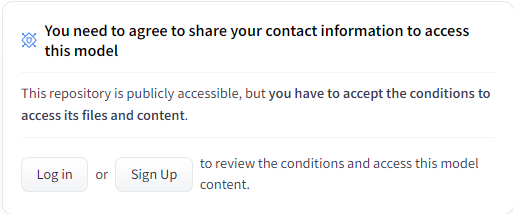

In [ ]:
# Configure BitsAndBytes for efficient model loading
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype="float16",
    bnb_4bit_use_double_quant=False,
)

# Load the model with the above configuration
model = AutoModelForCausalLM.from_pretrained(
    "mistralai/Mistral-7B-Instruct-v0.1",
    quantization_config=bnb_config,
    do_sample=True,

)

# Initialize tokenizer and set padding
tokenizer = AutoTokenizer.from_pretrained("mistralai/Mistral-7B-Instruct-v0.1")
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

`low_cpu_mem_usage` was None, now set to True since model is quantized.


model.safetensors.index.json:   0%|          | 0.00/25.1k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.94G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.47k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/72.0 [00:00<?, ?B/s]

* **Bits and Bytes Configuration:** This configuration allows the model to be loaded efficiently using 4-bit quantization.
* **AutoModelForCausalLM:** Loads a causal language model.
* **AutoTokenizer:** Initializes the tokenizer for the model.

## Set up Text Generation Pipeline
We set up the text generation pipeline with specific parameters to control the output, such as temperature and repetition penalty.

In [ ]:
# Set up the text generation pipeline with specific parameters
text_generation_pipeline = transformers.pipeline(
    model=model,
    tokenizer=tokenizer,
    temperature=0.00001,
    task="text-generation",
    repetition_penalty=1.1,
    return_full_text=True,
    max_new_tokens=2000,

)

# Create a HuggingFacePipeline instance for text generation
mistral_llm = HuggingFacePipeline(pipeline=text_generation_pipeline)

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:139: LangChainDeprecationWarning: The class `HuggingFacePipeline` was deprecated in LangChain 0.0.37 and will be removed in 0.3. An updated version of the class exists in the langchain-huggingface package and should be used instead. To use it run `pip install -U langchain-huggingface` and import as `from langchain_huggingface import HuggingFacePipeline`.
  warn_deprecated(


* **Pipeline:** Sets up the text generation pipeline with parameters like temperature and repetition penalty.
* **HuggingFacePipeline:** Wraps the text generation pipeline for use in LangChain.

## Prepare the Prompt Template that demands that the answer will be from the given context
The prompt template defines how we want the language model to respond, ensuring the answers are based on the provided context.

In [ ]:
# Define the prompt template for generating text
prompt_template = """
Instruction: prompt=f"Answer the following question based only on the provided context:{context}
If the answer is contained in the context, print "Answer:", and provide the answer from the context.
Also print "reference:" and show me from which part of the context your retrieved this answer.
If the answer does not appear in the context, answer: \"The answer isn't in the data you supplied\""

Question:
{question}
"""

prompt = PromptTemplate(
   input_variables=["context", "question"],
   template=prompt_template,
)

## Create LLM Chain
We create an LLM chain that links the language model with the prompt template, enabling us to generate responses based on context.

In [ ]:
llm_chain = LLMChain(llm=mistral_llm, prompt=prompt)

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:139: LangChainDeprecationWarning: The class `LLMChain` was deprecated in LangChain 0.1.17 and will be removed in 0.3.0. Use RunnableSequence, e.g., `prompt | llm` instead.
  warn_deprecated(


##  Load and Process PDF Documents
We load and process a PDF document to use as our knowledge base. This involves cleaning the content for better retrieval and indexing.

[Here is a link for downloading Harry Potter and the Sorcerers Stone.](https://docenti.unimc.it/antonella.pascali/teaching/2018/19055/files/ultima-lezione/harry-potter-and-the-philosophers-stone)

In [ ]:
path ="/content/Harry Potter and the Sorcerers Stone.pdf"
# path ="/content/cohen23b.pdf"

In [ ]:
from langchain_community.document_loaders import PyPDFLoader
loader = PyPDFLoader(path)
pages = loader.load_and_split()

In [ ]:
# Create a deep copy of the pages list to retain original objects intact
import copy
cleaned_pages = copy.deepcopy(pages)

# Clean the page_content of each page in the cleaned_pages list
for page in cleaned_pages:
    page.page_content = page.page_content.replace('\t', ' ')  # Replace tab characters with spaces

# Now, cleaned_pages contains the original objects with cleaned page_content

## Index Documents with FAISS
We index the cleaned documents using FAISS for efficient retrieval. FAISS allows us to perform similarity searches on dense vectors, making it ideal for retrieving relevant documents based on our queries.

In [ ]:
# Index the processed documents with FAISS for efficient retrieval
db = FAISS.from_documents(
    cleaned_pages,
    HuggingFaceEmbeddings(model_name='sentence-transformers/all-mpnet-base-v2')
)

# Convert the FAISS index into a retriever
retriever = db.as_retriever()

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:139: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 0.3.0. An updated version of the class exists in the langchain-huggingface package and should be used instead. To use it run `pip install -U langchain-huggingface` and import as `from langchain_huggingface import HuggingFaceEmbeddings`.
  warn_deprecated(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

* **FAISS:** Indexes the documents for efficient retrieval using FAISS.
* **HuggingFaceEmbeddings:** Generates embeddings using a sentence-transformer model.

## Save the retriever db to the disk (or cloud)
To ensure our retriever can be reused, we save it to disk using pickle. We also mount Google Drive to store the file for easy access.

In [ ]:
import pickle
def save_object(obj, filename):
    with open(filename, 'wb') as outp:  # Overwrites any existing file.
        pickle.dump(obj, outp, pickle.HIGHEST_PROTOCOL)
def load_object(filename):
    with open(filename, 'rb') as inp:  # Open the file in binary read mode
        obj = pickle.load(inp)
    return obj

In [ ]:
save_object(retriever, 'hp_retriever.pkl')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Define the source path of your file (the one you want to copy)
source_path = '/content/hp_retriever.pkl'

# Define the destination path in your Google Drive
destination_path = '/content/drive/My Drive/rag/retriever_file_hp'  # Update this path

In [ ]:
# Copying the file
import shutil
shutil.copy(source_path, destination_path)

print(f"File copied to Google Drive successfully: {destination_path}")

File copied to Google Drive successfully: /content/drive/My Drive/rag/retriever_file_hp


In [ ]:
loaded_retriever= load_object(source_path)

## Asking a Question
We define a question to test our RAG system. The question is used to retrieve relevant documents and generate an answer based on the content.

In [ ]:
# question = "who is obama?"
# question = "who is Harry?"
# question = "who is Harry Potter?"
# question = "who is Hermione?"
question = "who is better - Dumbledore or Snape. And why?"

## Retrieving Relevant Pages
Using the retriever, we get the most relevant documents for the given question.

In [ ]:
docs = loaded_retriever.get_relevant_documents(question)

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:139: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 0.3.0. Use invoke instead.
  warn_deprecated(


## Creating the Context
We concatenate the content of the retrieved documents to form a context string, which will be used by the language model to generate an answer.

In [ ]:
context = " ".join(doc.page_content for doc in docs)

In [ ]:
context

'242"Well, they did rather detest each other. Not unlike yourself and Mr.\nMalfoy. And then, your father did something Snape could never forgive."\n"What?""He saved his life."\n"What?"\n"Yes..." said Dumbledore dreamily. "Funny, the way people\'s minds work,\nisn\'t it? Professor Snape couldn\'t bear being in your father\'s debt....I do believe he worked so hard to protect you this year because he feltthat would make him and your father even. Then he could go back to\nhating your father\'s memory in peace...."\nHarry tried to understand this but it made his head pound, so he\nstopped.\n"And sir, there\'s one more thing..."\n"Just the one?"\n"How did I get the Stone out of the mirror?""Ah, now, I\'m glad you asked me that. It was one of my more brilliant\nideas, and between you and me, that\'s saying something. You see, only\none who wanted to find the Stone -- find it, but not use it -- would be\nable to get it, otherwise they\'d just see themselves making gold ordrinking Elixir of Lif

## Executing the Chain and Displaying the Response
Finally, we execute the LLM chain with the context and question to generate and display the answer.

In [ ]:
result = llm_chain.run(context=context, question=question)

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:139: LangChainDeprecationWarning: The method `Chain.run` was deprecated in langchain 0.1.0 and will be removed in 0.3.0. Use invoke instead.
  warn_deprecated(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:515: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `1e-05` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


In [ ]:
print(result)


Instruction: prompt=f"Answer the following question based only on the provided context:242"Well, they did rather detest each other. Not unlike yourself and Mr.
Malfoy. And then, your father did something Snape could never forgive."
"What?""He saved his life."
"What?"
"Yes..." said Dumbledore dreamily. "Funny, the way people's minds work,
isn't it? Professor Snape couldn't bear being in your father's debt....I do believe he worked so hard to protect you this year because he feltthat would make him and your father even. Then he could go back to
hating your father's memory in peace...."
Harry tried to understand this but it made his head pound, so he
stopped.
"And sir, there's one more thing..."
"Just the one?"
"How did I get the Stone out of the mirror?""Ah, now, I'm glad you asked me that. It was one of my more brilliant
ideas, and between you and me, that's saying something. You see, only
one who wanted to find the Stone -- find it, but not use it -- would be
able to get it, otherwise

## Concepts Explained
* **LangChain:** A framework for building applications that use language models. It provides tools to chain together different components like document loaders, embeddings, and language models.
* **Tokenizer:** Converts text into tokens that the model can process. Tokenization is a crucial step for preparing text input for language models.
* **FAISS:** A library developed by Facebook AI for efficient similarity search and clustering of dense vectors. It is widely used for tasks like document retrieval and nearest neighbor search.
* **Bits and Bytes (bnb):** A library for model quantization, which reduces the size of models and increases efficiency without significantly sacrificing performance.
* **Hugging Face Transformers:** A popular library providing a wide range of pretrained models and tools for natural language processing (NLP) tasks.
* **PromptTemplate:** A template that defines the structure of the input to the language model. It helps in controlling how the model generates responses.


By following these steps, we have successfully built a Retrieval-Augmented
Generation (RAG) system that can retrieve relevant documents from a knowledge base and generate accurate answers using a large language model. This powerful combination of tools allows us to create sophisticated question-answering systems with minimal effort.

##Coding Tasks for RAG Workshop
In this section of the workshop, you'll apply your understanding of Retrieval-Augmented Generation (RAG) by completing hands-on coding tasks. These tasks will help reinforce the concepts discussed and give you practical experience in configuring and utilizing RAG systems.

###Task 1: Override Model's Knowledge with RAG Context
**Objective:** Configure the RAG system to ensure that it returns an answer based solely on the provided context, overriding any prior knowledge the model might have.

**Instructions:**
1. **Load the Provided Context:** Use the RAG system to load a context where "Harry Potter is a cat".
2. **Prompt the Model:** Create a prompt to ask questions about Harry Potter and ensure the responses are based on the provided context, not the model's pre-existing knowledge.
3. **Test the Configuration:** Ask questions like "Who is Harry Potter?" and "What is Harry Potter's species?" to verify that the responses adhere to the context.

In [ ]:
# Provided context
context = """
Harry Potter is a cat. He is not a wizard, but a feline who loves to explore magical places.
He has whiskers, fur, and a playful personality.
"""

# Define the prompt template
prompt_template = """
Instruction: Based on the provided context, answer the following questions.
{context}
Question:
{question}
"""

# Create the PromptTemplate instance
prompt = PromptTemplate(
   input_variables=["context", "question"],
   template=prompt_template,
)

# Create LLMChain
llm_chain = LLMChain(llm=mistral_llm, prompt=prompt)

# Ask questions
question1 = "Who is Harry Potter?"
question2 = "What is Harry Potter's species?"

# Run the chain with the context
result1 = llm_chain.run(context=context, question=question1)
result2 = llm_chain.run(context=context, question=question2)

print(f"Question: {question1}\nAnswer: {result1}")
print(f"Question: {question2}\nAnswer: {result2}")


**Expected Output:**
* **Question:** Who is Harry Potter?

  **Answer:** Harry Potter is a cat.
* **Question:** What is Harry Potter's species?

  **Answer:** Harry Potter's species is a cat.